In [2]:
import networkx as nx
import cassiopeia as cas
import pandas as pd
import pickle as pic
from tqdm import tqdm
import numpy as np
import inverse_whd

# Base parameters, no fitness
in_folder = "/data/yosef2/users/richardz/projects/CassiopeiaV2-Reproducibility/trees/exponential_plus_c/400cells/no_fit/char40/"
out_folder = "./benchmarking/"

# NJ with Inverse WHD

In [ ]:
def inv_whd(
    s1,
    s2,
    missing_state_indicator=-1,
    weights=None,
) -> float:

    h = cas.solver.dissimilarity_functions.weighted_hamming_distance(s1, s2, missing_state_indicator, weights)

    return 2 * inverse_whd.ewhd_inv( # todo: fill out params
        num_sites=40, 
        mut_rate=None, 
        collision_rate=None, 
        h=h, 
        time=None, 
        error_tolerance=None
    )

In [ ]:
for i in tqdm(range(50)):
    cm = pd.read_table(in_folder + "cm" + str(i) + ".txt", index_col = 0)
    # Note that we "mask" over heritable missing data, so that the algorithm is agnostic to the kind of missing data
    cm = cm.replace(-2, -1)
    
    recon_tree = cas.data.CassiopeiaTree(character_matrix = cm, missing_state_indicator = -1)
    
    # dists
    ground_truth_filepath = in_folder + "tree" + str(i) + ".pkl"
    ground_truth_tree = pic.load(open(ground_truth_filepath, "rb"))
    
    solver = cas.solver.NeighborJoiningSolver(add_root = True, dissimilarity_function=inv_whd) 
    
    # Note that we collapse mutationless edges, again to remove spurious effects from the output
    solver.solve(recon_tree, collapse_mutationless_edges = True)
    
    with open(out_folder + 'nj_inv_whd/' + "recon" + str(i), "w+") as f:
        # Write to newick
        f.write(recon_tree.get_newick())
        f.close()

100%|██████████| 50/50 [24:21<00:00, 29.23s/it]


In [ ]:
triplets = pd.DataFrame(
    columns=[
        "NumberOfCells",
        "Priors",
        "Fitness",
        "Stressor",
        "Parameter",
        "Algorithm",
        "Replicate",
        "Depth",
        "TripletsCorrect",
    ]
)
RF = pd.DataFrame(
    columns=[
        "NumberOfCells",
        "Priors",
        "Fitness",
        "Stressor",
        "Parameter",
        "Algorithm",
        "Replicate",
        "UnNormalizedRobinsonFoulds",
        "MaxRobinsonFoulds",
        "NormalizedRobinsonFoulds",
    ]
)


for i in tqdm(range(50)):
    ground_truth_filepath = in_folder + "tree" + str(i) + ".pkl"
    ground_truth_tree = pic.load(open(ground_truth_filepath, "rb"))
    
    recon_file_path = out_folder + 'nj_inv_whd/' + "recon" + str(i)
    reconstructed_tree = cas.data.CassiopeiaTree(
        tree=recon_file_path
    )
    
    triplet_correct = cas.critique.triplets_correct(
        ground_truth_tree,
        reconstructed_tree,
        number_of_trials=1000,
        min_triplets_at_depth=50,
    )[0]
    rf, rf_max = cas.critique.robinson_foulds(
        ground_truth_tree, reconstructed_tree
    )

    RF = RF.append(
        pd.Series(
            [
                400,
                "no_priors",
                "no_fit",
                "char",
                40,
                "SNJ",
                i,
                rf,
                rf_max,
                rf / rf_max,
            ],
            index=RF.columns,
        ),
        ignore_index=True,
    )

    for depth in triplet_correct:
        triplets = triplets.append(
            pd.Series(
                [
                    400,
                    "no_priors",
                    "no_fit",
                    "char",
                    40,
                    "SNJ",
                    i,
                    depth,
                    triplet_correct[depth],
                ],
                index=triplets.columns,
            ),
            ignore_index=True,
        )

RF.to_csv('./benchmarking/RF_nj_inv_whd.csv')
triplets.to_csv('./benchmarking/triplets_nj_inv_whd.csv')

100%|██████████| 50/50 [05:43<00:00,  6.87s/it]


# SNJ with Exp Dists

In [3]:
for i in tqdm(range(50)):
    cm = pd.read_table(in_folder + "cm" + str(i) + ".txt", index_col = 0)
    # Note that we "mask" over heritable missing data, so that the algorithm is agnostic to the kind of missing data
    cm = cm.replace(-2, -1)
    
    recon_tree = cas.data.CassiopeiaTree(character_matrix = cm, missing_state_indicator = -1)
    
    # dists
    ground_truth_filepath = in_folder + "tree" + str(i) + ".pkl"
    ground_truth_tree = pic.load(open(ground_truth_filepath, "rb"))
    dists = pd.DataFrame(columns=ground_truth_tree.leaves, index=ground_truth_tree.leaves)
    for leaf in ground_truth_tree.leaves:
        dists[leaf] = ground_truth_tree.get_distances(leaf, leaves_only=True).values()
        
    dists = np.exp(dists)
        
    recon_tree.set_dissimilarity_map(dists)
    
    solver = cas.solver.NeighborJoiningSolver(add_root = True)
    # Note that we collapse mutationless edges, again to remove spurious effects from the output
    solver.solve(recon_tree, collapse_mutationless_edges = False)
    
    with open(out_folder + 'snj_exp_dists/' + "recon" + str(i), "w+") as f:
        # Write to newick
        f.write(recon_tree.get_newick())
        f.close()

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
triplets = pd.DataFrame(
    columns=[
        "NumberOfCells",
        "Priors",
        "Fitness",
        "Stressor",
        "Parameter",
        "Algorithm",
        "Replicate",
        "Depth",
        "TripletsCorrect",
    ]
)
RF = pd.DataFrame(
    columns=[
        "NumberOfCells",
        "Priors",
        "Fitness",
        "Stressor",
        "Parameter",
        "Algorithm",
        "Replicate",
        "UnNormalizedRobinsonFoulds",
        "MaxRobinsonFoulds",
        "NormalizedRobinsonFoulds",
    ]
)


for i in tqdm(range(50)):
    ground_truth_filepath = in_folder + "tree" + str(i) + ".pkl"
    ground_truth_tree = pic.load(open(ground_truth_filepath, "rb"))
    
    recon_file_path = out_folder + 'snj_exp_dists/' + "recon" + str(i)
    reconstructed_tree = cas.data.CassiopeiaTree(
        tree=recon_file_path
    )
    
    triplet_correct = cas.critique.triplets_correct(
        ground_truth_tree,
        reconstructed_tree,
        number_of_trials=1000,
        min_triplets_at_depth=50,
    )[0]
    rf, rf_max = cas.critique.robinson_foulds(
        ground_truth_tree, reconstructed_tree
    )

    RF = RF.append(
        pd.Series(
            [
                400,
                "no_priors",
                "no_fit",
                "char",
                40,
                "SNJ",
                i,
                rf,
                rf_max,
                rf / rf_max,
            ],
            index=RF.columns,
        ),
        ignore_index=True,
    )

    for depth in triplet_correct:
        triplets = triplets.append(
            pd.Series(
                [
                    400,
                    "no_priors",
                    "no_fit",
                    "char",
                    40,
                    "SNJ",
                    i,
                    depth,
                    triplet_correct[depth],
                ],
                index=triplets.columns,
            ),
            ignore_index=True,
        )

RF.to_csv('./benchmarking/RF_snj_exp_dists.csv')
triplets.to_csv('./benchmarking/triplets_snj_exp_dists.csv')

100%|██████████| 50/50 [05:43<00:00,  6.87s/it]


# NJ with Dists

In [21]:
for i in tqdm(range(50)):
    cm = pd.read_table(in_folder + "cm" + str(i) + ".txt", index_col = 0)
    # Note that we "mask" over heritable missing data, so that the algorithm is agnostic to the kind of missing data
    cm = cm.replace(-2, -1)
    
    recon_tree = cas.data.CassiopeiaTree(character_matrix = cm, missing_state_indicator = -1)
    
    # dists
    ground_truth_filepath = in_folder + "tree" + str(i) + ".pkl"
    ground_truth_tree = pic.load(open(ground_truth_filepath, "rb"))
    dists = pd.DataFrame(columns=ground_truth_tree.leaves, index=ground_truth_tree.leaves)
    for leaf in ground_truth_tree.leaves:
        dists[leaf] = ground_truth_tree.get_distances(leaf, leaves_only=True).values()
        
    recon_tree.set_dissimilarity_map(dists)
    
    solver = cas.solver.NeighborJoiningSolver(add_root = True)
    # Note that we collapse mutationless edges, again to remove spurious effects from the output
    solver.solve(recon_tree, collapse_mutationless_edges = False)
    
    with open(out_folder + 'nj_dists/' + "recon" + str(i), "w+") as f:
        # Write to newick
        f.write(recon_tree.get_newick())
        f.close()

100%|██████████| 50/50 [25:31<00:00, 30.63s/it]


In [22]:
triplets = pd.DataFrame(
    columns=[
        "NumberOfCells",
        "Priors",
        "Fitness",
        "Stressor",
        "Parameter",
        "Algorithm",
        "Replicate",
        "Depth",
        "TripletsCorrect",
    ]
)
RF = pd.DataFrame(
    columns=[
        "NumberOfCells",
        "Priors",
        "Fitness",
        "Stressor",
        "Parameter",
        "Algorithm",
        "Replicate",
        "UnNormalizedRobinsonFoulds",
        "MaxRobinsonFoulds",
        "NormalizedRobinsonFoulds",
    ]
)


for i in tqdm(range(50)):
    ground_truth_filepath = in_folder + "tree" + str(i) + ".pkl"
    ground_truth_tree = pic.load(open(ground_truth_filepath, "rb"))
    
    recon_file_path = out_folder + 'nj_dists/' + "recon" + str(i)
    reconstructed_tree = cas.data.CassiopeiaTree(
        tree=recon_file_path
    )
    
    triplet_correct = cas.critique.triplets_correct(
        ground_truth_tree,
        reconstructed_tree,
        number_of_trials=1000,
        min_triplets_at_depth=50,
    )[0]
    rf, rf_max = cas.critique.robinson_foulds(
        ground_truth_tree, reconstructed_tree
    )

    RF = RF.append(
        pd.Series(
            [
                400,
                "no_priors",
                "no_fit",
                "char",
                40,
                "SNJ",
                i,
                rf,
                rf_max,
                rf / rf_max,
            ],
            index=RF.columns,
        ),
        ignore_index=True,
    )

    for depth in triplet_correct:
        triplets = triplets.append(
            pd.Series(
                [
                    400,
                    "no_priors",
                    "no_fit",
                    "char",
                    40,
                    "SNJ",
                    i,
                    depth,
                    triplet_correct[depth],
                ],
                index=triplets.columns,
            ),
            ignore_index=True,
        )

RF.to_csv('./benchmarking/RF_nj_dists.csv')
triplets.to_csv('./benchmarking/triplets_nj_dists.csv')

100%|██████████| 50/50 [05:47<00:00,  6.94s/it]


# SNJ with Dists

In [7]:
for i in tqdm(range(50)):
    cm = pd.read_table(in_folder + "cm" + str(i) + ".txt", index_col = 0)
    # Note that we "mask" over heritable missing data, so that the algorithm is agnostic to the kind of missing data
    cm = cm.replace(-2, -1)
    
    recon_tree = cas.data.CassiopeiaTree(character_matrix = cm, missing_state_indicator = -1)
    
    # dists
    ground_truth_filepath = in_folder + "tree" + str(i) + ".pkl"
    ground_truth_tree = pic.load(open(ground_truth_filepath, "rb"))
    dists = pd.DataFrame(columns=ground_truth_tree.leaves, index=ground_truth_tree.leaves)
    for leaf in ground_truth_tree.leaves:
        dists[leaf] = ground_truth_tree.get_distances(leaf, leaves_only=True).values()
        
    recon_tree.set_dissimilarity_map(dists)
    
    solver = cas.solver.SpectralNeighborJoiningSolver(add_root = True)
    # Note that we collapse mutationless edges, again to remove spurious effects from the output
    solver.solve(recon_tree, collapse_mutationless_edges = False)
    
    with open(out_folder + 'dists/' + "recon" + str(i), "w+") as f:
        # Write to newick
        f.write(recon_tree.get_newick())
        f.close()

100%|██████████| 50/50 [48:35<00:00, 58.31s/it]


In [8]:
triplets = pd.DataFrame(
    columns=[
        "NumberOfCells",
        "Priors",
        "Fitness",
        "Stressor",
        "Parameter",
        "Algorithm",
        "Replicate",
        "Depth",
        "TripletsCorrect",
    ]
)
RF = pd.DataFrame(
    columns=[
        "NumberOfCells",
        "Priors",
        "Fitness",
        "Stressor",
        "Parameter",
        "Algorithm",
        "Replicate",
        "UnNormalizedRobinsonFoulds",
        "MaxRobinsonFoulds",
        "NormalizedRobinsonFoulds",
    ]
)


for i in tqdm(range(50)):
    ground_truth_filepath = in_folder + "tree" + str(i) + ".pkl"
    ground_truth_tree = pic.load(open(ground_truth_filepath, "rb"))
    
    recon_file_path = out_folder + 'dists/' + "recon" + str(i)
    reconstructed_tree = cas.data.CassiopeiaTree(
        tree=recon_file_path
    )
    
    triplet_correct = cas.critique.triplets_correct(
        ground_truth_tree,
        reconstructed_tree,
        number_of_trials=1000,
        min_triplets_at_depth=50,
    )[0]
    rf, rf_max = cas.critique.robinson_foulds(
        ground_truth_tree, reconstructed_tree
    )

    RF = RF.append(
        pd.Series(
            [
                400,
                "no_priors",
                "no_fit",
                "char",
                40,
                "SNJ",
                i,
                rf,
                rf_max,
                rf / rf_max,
            ],
            index=RF.columns,
        ),
        ignore_index=True,
    )

    for depth in triplet_correct:
        triplets = triplets.append(
            pd.Series(
                [
                    400,
                    "no_priors",
                    "no_fit",
                    "char",
                    40,
                    "SNJ",
                    i,
                    depth,
                    triplet_correct[depth],
                ],
                index=triplets.columns,
            ),
            ignore_index=True,
        )

RF.to_csv('./benchmarking/RF_dists.csv')
triplets.to_csv('./benchmarking/triplets_dists.csv')

100%|██████████| 50/50 [05:24<00:00,  6.49s/it]


# SNJ

In [12]:
for i in tqdm(range(50)):
    cm = pd.read_table(in_folder + "cm" + str(i) + ".txt", index_col = 0)
    # Note that we "mask" over heritable missing data, so that the algorithm is agnostic to the kind of missing data
    cm = cm.replace(-2, -1)
    
    recon_tree = cas.data.CassiopeiaTree(character_matrix = cm, missing_state_indicator = -1)
    
    solver = cas.solver.SpectralNeighborJoiningSolver(add_root = True)
    # Note that we collapse mutationless edges, again to remove spurious effects from the output
    solver.solve(recon_tree, collapse_mutationless_edges = True)
    
    with open(out_folder + "recon" + str(i), "w+") as f:
        # Write to newick
        f.write(recon_tree.get_newick())
        f.close()

100%|██████████| 50/50 [26:53<00:00, 32.28s/it]


In [21]:
triplets = pd.DataFrame(
    columns=[
        "NumberOfCells",
        "Priors",
        "Fitness",
        "Stressor",
        "Parameter",
        "Algorithm",
        "Replicate",
        "Depth",
        "TripletsCorrect",
    ]
)
RF = pd.DataFrame(
    columns=[
        "NumberOfCells",
        "Priors",
        "Fitness",
        "Stressor",
        "Parameter",
        "Algorithm",
        "Replicate",
        "UnNormalizedRobinsonFoulds",
        "MaxRobinsonFoulds",
        "NormalizedRobinsonFoulds",
    ]
)


for i in tqdm(range(50)):
    ground_truth_filepath = in_folder + "tree" + str(i) + ".pkl"
    ground_truth_tree = pic.load(open(ground_truth_filepath, "rb"))
    
    recon_file_path = out_folder + "recon" + str(i)
    reconstructed_tree = cas.data.CassiopeiaTree(
        tree=recon_file_path
    )
    
    triplet_correct = cas.critique.triplets_correct(
        ground_truth_tree,
        reconstructed_tree,
        number_of_trials=1000,
        min_triplets_at_depth=50,
    )[0]
    rf, rf_max = cas.critique.robinson_foulds(
        ground_truth_tree, reconstructed_tree
    )

    RF = RF.append(
        pd.Series(
            [
                400,
                "no_priors",
                "no_fit",
                "char",
                40,
                "SNJ",
                i,
                rf,
                rf_max,
                rf / rf_max,
            ],
            index=RF.columns,
        ),
        ignore_index=True,
    )

    for depth in triplet_correct:
        triplets = triplets.append(
            pd.Series(
                [
                    400,
                    "no_priors",
                    "no_fit",
                    "char",
                    40,
                    "SNJ",
                    i,
                    depth,
                    triplet_correct[depth],
                ],
                index=triplets.columns,
            ),
            ignore_index=True,
        )

RF.to_csv('./benchmarking/RF_snj.csv')
triplets.to_csv('./benchmarking/triplets_snj.csv')

100%|██████████| 50/50 [05:23<00:00,  6.47s/it]


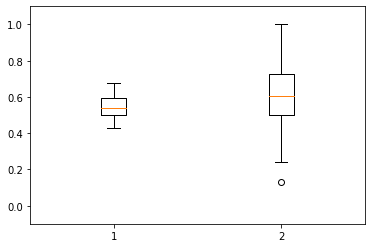

In [56]:
import matplotlib.pyplot as plt

plt.clf()
plt.boxplot([RF['NormalizedRobinsonFoulds'], triplets['TripletsCorrect']])
plt
plt.ylim(-0.1, 1.1)
plt.show()

# Running OG SNJ

In [144]:
#!pip install https://github.com/aizeny/snj
import spectraltree 
from dendropy import Tree, TaxonNamespace

In [64]:
for i in tqdm(range(50)):
    cm = pd.read_table(in_folder + "cm" + str(i) + ".txt", index_col = 0)
    # Note that we "mask" over heritable missing data, so that the algorithm is agnostic to the kind of missing data
    cm = cm.replace(-2, -1)
    recon_tree = cas.data.CassiopeiaTree(character_matrix = cm, missing_state_indicator = -1)

    # Reconstruct tree in OG mode, then convert to CassiopeiaTree
    namespace = TaxonNamespace(cm.index)

    taxa_meta = spectraltree.TaxaMetadata(
        namespace,
        [i for i in namespace] 
    )
    snj = spectraltree.SpectralNeighborJoining(spectraltree.JC_similarity_matrix)
    solved_newick = str(snj(cm.values, taxa_meta)) + ';'

    recon_tree.populate_tree(solved_newick)
    recon_tree.collapse_mutationless_edges(True)
    
    with open(out_folder + 'og/' + "recon" + str(i), "w+") as f:
        # Write to newick
        f.write(recon_tree.get_newick())
        f.close()

100%|██████████| 50/50 [27:39<00:00, 33.20s/it]


In [20]:
triplets_og = pd.DataFrame(
    columns=[
        "NumberOfCells",
        "Priors",
        "Fitness",
        "Stressor",
        "Parameter",
        "Algorithm",
        "Replicate",
        "Depth",
        "TripletsCorrect",
    ]
)
RF_og = pd.DataFrame(
    columns=[
        "NumberOfCells",
        "Priors",
        "Fitness",
        "Stressor",
        "Parameter",
        "Algorithm",
        "Replicate",
        "UnNormalizedRobinsonFoulds",
        "MaxRobinsonFoulds",
        "NormalizedRobinsonFoulds",
    ]
)


for i in tqdm(range(50)):
    ground_truth_filepath = in_folder + "tree" + str(i) + ".pkl"
    ground_truth_tree = pic.load(open(ground_truth_filepath, "rb"))
    
    recon_file_path = out_folder + 'og/' + "recon" + str(i)
    reconstructed_tree = cas.data.CassiopeiaTree(
        tree=recon_file_path
    )
    
    triplet_correct = cas.critique.triplets_correct(
        ground_truth_tree,
        reconstructed_tree,
        number_of_trials=1000,
        min_triplets_at_depth=50,
    )[0]
    rf, rf_max = cas.critique.robinson_foulds(
        ground_truth_tree, reconstructed_tree
    )

    RF_og = RF_og.append(
        pd.Series(
            [
                400,
                "no_priors",
                "no_fit",
                "char",
                40,
                "SNJ",
                i,
                rf,
                rf_max,
                rf / rf_max,
            ],
            index=RF_og.columns,
        ),
        ignore_index=True,
    )

    for depth in triplet_correct:
        triplets_og = triplets_og.append(
            pd.Series(
                [
                    400,
                    "no_priors",
                    "no_fit",
                    "char",
                    40,
                    "SNJ",
                    i,
                    depth,
                    triplet_correct[depth],
                ],
                index=triplets_og.columns,
            ),
            ignore_index=True,
        )

RF_og.to_csv('./benchmarking/RF_og.csv')
triplets_og.to_csv('./benchmarking/triplets_og.csv')

100%|██████████| 50/50 [05:20<00:00,  6.41s/it]


In [132]:
# 
dd_tree_recon = Tree.get(
    data=reconstructed_tree.get_newick(),
    schema='newick'
)

dd_tree_ref = Tree.get(
    data=ground_truth_tree.get_newick(),
    schema='newick',
    taxon_namespace=dd_tree_recon.taxon_namespace
)

In [142]:
rf, rf_max = cas.critique.robinson_foulds(
        ground_truth_tree, reconstructed_tree
    )
rf

448

In [141]:
RF_snj,F1 = spectraltree.compare_trees(dd_tree_recon, dd_tree_ref)
print('Normalized RF for SNJ:', RF_snj)

Normalized RF for SNJ: 448


# STDR

In [10]:
from dendropy import Tree, TaxonNamespace
from spectraltree import STDR

for i in tqdm(range(50)):
    cm = pd.read_table(in_folder + "cm" + str(i) + ".txt", index_col = 0)
    # Note that we "mask" over heritable missing data, so that the algorithm is agnostic to the kind of missing data
    cm = cm.replace(-2, -1)
    recon_tree = cas.data.CassiopeiaTree(character_matrix = cm, missing_state_indicator = -1)

    # Reconstruct tree in OG mode, then convert to CassiopeiaTree
    namespace = TaxonNamespace(cm.index)

    taxa_meta = spectraltree.TaxaMetadata(
        namespace,
        [i for i in namespace] 
    )
    stdr_nj = STDR(spectraltree.NeighborJoining,spectraltree.JC_similarity_matrix)
    tree_stdr_nj = stdr_nj(cm.values, 
        taxa_metadata= taxa_meta, 
        threshold = 64,
        min_split = 1,
        merge_method = "least_square", 
        verbose=False)
        
    solved_newick = str(tree_stdr_nj) + ';'

    recon_tree.populate_tree(solved_newick)
    recon_tree.collapse_mutationless_edges(True)
    
    with open(out_folder + 'stdr/' + "recon" + str(i), "w+") as f:
        # Write to newick
        f.write(recon_tree.get_newick())
        f.close()

100%|██████████| 50/50 [08:06<00:00,  9.74s/it]


In [11]:
triplets_stdr = pd.DataFrame(
    columns=[
        "NumberOfCells",
        "Priors",
        "Fitness",
        "Stressor",
        "Parameter",
        "Algorithm",
        "Replicate",
        "Depth",
        "TripletsCorrect",
    ]
)
RF_stdr = pd.DataFrame(
    columns=[
        "NumberOfCells",
        "Priors",
        "Fitness",
        "Stressor",
        "Parameter",
        "Algorithm",
        "Replicate",
        "UnNormalizedRobinsonFoulds",
        "MaxRobinsonFoulds",
        "NormalizedRobinsonFoulds",
    ]
)


for i in tqdm(range(50)):
    ground_truth_filepath = in_folder + "tree" + str(i) + ".pkl"
    ground_truth_tree = pic.load(open(ground_truth_filepath, "rb"))
    
    recon_file_path = out_folder + 'stdr/' + "recon" + str(i)
    reconstructed_tree = cas.data.CassiopeiaTree(
        tree=recon_file_path
    )
    
    triplet_correct = cas.critique.triplets_correct(
        ground_truth_tree,
        reconstructed_tree,
        number_of_trials=1000,
        min_triplets_at_depth=50,
    )[0]
    rf, rf_max = cas.critique.robinson_foulds(
        ground_truth_tree, reconstructed_tree
    )

    RF_stdr = RF_stdr.append(
        pd.Series(
            [
                400,
                "no_priors",
                "no_fit",
                "char",
                40,
                "SNJ",
                i,
                rf,
                rf_max,
                rf / rf_max,
            ],
            index=RF_stdr.columns,
        ),
        ignore_index=True,
    )

    for depth in triplet_correct:
        triplets_stdr = triplets_stdr.append(
            pd.Series(
                [
                    400,
                    "no_priors",
                    "no_fit",
                    "char",
                    40,
                    "SNJ",
                    i,
                    depth,
                    triplet_correct[depth],
                ],
                index=triplets_stdr.columns,
            ),
            ignore_index=True,
        )

RF_stdr.to_csv('./benchmarking/RF_stdr.csv')
triplets_stdr.to_csv('./benchmarking/triplets_stdr.csv')

100%|██████████| 50/50 [05:21<00:00,  6.42s/it]


# NJ Yaffe

In [12]:
#!pip install https://github.com/aizeny/snj
import spectraltree 
from dendropy import Tree, TaxonNamespace

In [23]:
for i in tqdm(range(50)):
    cm = pd.read_table(in_folder + "cm" + str(i) + ".txt", index_col = 0)
    # Note that we "mask" over heritable missing data, so that the algorithm is agnostic to the kind of missing data
    cm = cm.replace(-2, -1)
    recon_tree = cas.data.CassiopeiaTree(character_matrix = cm, missing_state_indicator = -1)

    # Reconstruct tree in OG mode, then convert to CassiopeiaTree
    namespace = TaxonNamespace(cm.index)

    taxa_meta = spectraltree.TaxaMetadata(
        namespace,
        [i for i in namespace] 
    )
    snj = spectraltree.NeighborJoining(spectraltree.JC_similarity_matrix)
    solved_newick = str(snj(cm.values, taxa_meta)) + ';'

    recon_tree.populate_tree(solved_newick)
    recon_tree.collapse_mutationless_edges(True)
    
    with open(out_folder + 'nj/' + "recon" + str(i), "w+") as f:
        # Write to newick
        f.write(recon_tree.get_newick())
        f.close()

100%|██████████| 50/50 [09:15<00:00, 11.12s/it]


In [24]:
triplets_nj = pd.DataFrame(
    columns=[
        "NumberOfCells",
        "Priors",
        "Fitness",
        "Stressor",
        "Parameter",
        "Algorithm",
        "Replicate",
        "Depth",
        "TripletsCorrect",
    ]
)
RF_nj = pd.DataFrame(
    columns=[
        "NumberOfCells",
        "Priors",
        "Fitness",
        "Stressor",
        "Parameter",
        "Algorithm",
        "Replicate",
        "UnNormalizedRobinsonFoulds",
        "MaxRobinsonFoulds",
        "NormalizedRobinsonFoulds",
    ]
)


for i in tqdm(range(50)):
    ground_truth_filepath = in_folder + "tree" + str(i) + ".pkl"
    ground_truth_tree = pic.load(open(ground_truth_filepath, "rb"))
    
    recon_file_path = out_folder + 'nj/' + "recon" + str(i)
    reconstructed_tree = cas.data.CassiopeiaTree(
        tree=recon_file_path
    )
    
    triplet_correct = cas.critique.triplets_correct(
        ground_truth_tree,
        reconstructed_tree,
        number_of_trials=1000,
        min_triplets_at_depth=50,
    )[0]
    rf, rf_max = cas.critique.robinson_foulds(
        ground_truth_tree, reconstructed_tree
    )

    RF_nj = RF_nj.append(
        pd.Series(
            [
                400,
                "no_priors",
                "no_fit",
                "char",
                40,
                "SNJ",
                i,
                rf,
                rf_max,
                rf / rf_max,
            ],
            index=RF_nj.columns,
        ),
        ignore_index=True,
    )

    for depth in triplet_correct:
        triplets_nj = triplets_nj.append(
            pd.Series(
                [
                    400,
                    "no_priors",
                    "no_fit",
                    "char",
                    40,
                    "SNJ",
                    i,
                    depth,
                    triplet_correct[depth],
                ],
                index=triplets_nj.columns,
            ),
            ignore_index=True,
        )

RF_nj.to_csv('./benchmarking/RF_nj.csv')
triplets_nj.to_csv('./benchmarking/triplets_nj.csv')

100%|██████████| 50/50 [05:22<00:00,  6.44s/it]


# SNJ Yaffe NEGATIVE CONTROL

In [30]:
#!pip install https://github.com/aizeny/snj
import spectraltree 
from dendropy import Tree, TaxonNamespace
import random

In [32]:
for i in tqdm(range(50)):
    cm = pd.read_table(in_folder + "cm" + str(i) + ".txt", index_col = 0)
    # Note that we "mask" over heritable missing data, so that the algorithm is agnostic to the kind of missing data
    cm = cm.replace(-2, -1)
    recon_tree = cas.data.CassiopeiaTree(character_matrix = cm, missing_state_indicator = -1)

    # Reconstruct tree in OG mode, then convert to CassiopeiaTree
    tmp_idxs = cm.index.values
    random.shuffle(tmp_idxs) # !!
    namespace = TaxonNamespace(tmp_idxs)

    taxa_meta = spectraltree.TaxaMetadata(
        namespace,
        [i for i in namespace] 
    )
    snj = spectraltree.SpectralNeighborJoining(spectraltree.JC_similarity_matrix)
    solved_newick = str(snj(cm.values, taxa_meta)) + ';'

    recon_tree.populate_tree(solved_newick)
    recon_tree.collapse_mutationless_edges(True)
    
    with open(out_folder + 'snj_neg/' + "recon" + str(i), "w+") as f:
        # Write to newick
        f.write(recon_tree.get_newick())
        f.close()

100%|██████████| 50/50 [26:41<00:00, 32.03s/it]


In [33]:
triplets_snj_neg = pd.DataFrame(
    columns=[
        "NumberOfCells",
        "Priors",
        "Fitness",
        "Stressor",
        "Parameter",
        "Algorithm",
        "Replicate",
        "Depth",
        "TripletsCorrect",
    ]
)
RF_snj_neg = pd.DataFrame(
    columns=[
        "NumberOfCells",
        "Priors",
        "Fitness",
        "Stressor",
        "Parameter",
        "Algorithm",
        "Replicate",
        "UnNormalizedRobinsonFoulds",
        "MaxRobinsonFoulds",
        "NormalizedRobinsonFoulds",
    ]
)


for i in tqdm(range(50)):
    ground_truth_filepath = in_folder + "tree" + str(i) + ".pkl"
    ground_truth_tree = pic.load(open(ground_truth_filepath, "rb"))
    
    recon_file_path = out_folder + 'snj_neg/' + "recon" + str(i)
    reconstructed_tree = cas.data.CassiopeiaTree(
        tree=recon_file_path
    )
    
    triplet_correct = cas.critique.triplets_correct(
        ground_truth_tree,
        reconstructed_tree,
        number_of_trials=1000,
        min_triplets_at_depth=50,
    )[0]
    rf, rf_max = cas.critique.robinson_foulds(
        ground_truth_tree, reconstructed_tree
    )

    RF_snj_neg = RF_snj_neg.append(
        pd.Series(
            [
                400,
                "no_priors",
                "no_fit",
                "char",
                40,
                "SNJ",
                i,
                rf,
                rf_max,
                rf / rf_max,
            ],
            index=RF_snj_neg.columns,
        ),
        ignore_index=True,
    )

    for depth in triplet_correct:
        triplets_snj_neg = triplets_snj_neg.append(
            pd.Series(
                [
                    400,
                    "no_priors",
                    "no_fit",
                    "char",
                    40,
                    "SNJ",
                    i,
                    depth,
                    triplet_correct[depth],
                ],
                index=triplets_snj_neg.columns,
            ),
            ignore_index=True,
        )

RF_snj_neg.to_csv('./benchmarking/RF_snj_neg.csv')
triplets_snj_neg.to_csv('./benchmarking/triplets_snj_neg.csv')

100%|██████████| 50/50 [05:19<00:00,  6.40s/it]


# SNJ Yaffe from Similarity Matrix

In [ ]:
#!pip install https://github.com/aizeny/snj
import spectraltree 
from dendropy import Tree, TaxonNamespace
import random

In [ ]:
for i in tqdm(range(50)):
    cm = pd.read_table(in_folder + "cm" + str(i) + ".txt", index_col = 0)
    # Note that we "mask" over heritable missing data, so that the algorithm is agnostic to the kind of missing data
    cm = cm.replace(-2, -1)
    recon_tree = cas.data.CassiopeiaTree(character_matrix = cm, missing_state_indicator = -1)

    # Reconstruct tree in OG mode, then convert to CassiopeiaTree
    tmp_idxs = cm.index.values
    random.shuffle(tmp_idxs) # !!
    namespace = TaxonNamespace(tmp_idxs)

    taxa_meta = spectraltree.TaxaMetadata(
        namespace,
        [i for i in namespace] 
    )
    snj = spectraltree.SpectralNeighborJoining(spectraltree.JC_similarity_matrix)
    solved_newick = str(snj(cm.values, taxa_meta)) + ';' # todo: change this?

    recon_tree.populate_tree(solved_newick)
    recon_tree.collapse_mutationless_edges(True)
    
    with open(out_folder + 'snj_sm/' + "recon" + str(i), "w+") as f:
        # Write to newick
        f.write(recon_tree.get_newick())
        f.close()

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
triplets_snj_sm = pd.DataFrame(
    columns=[
        "NumberOfCells",
        "Priors",
        "Fitness",
        "Stressor",
        "Parameter",
        "Algorithm",
        "Replicate",
        "Depth",
        "TripletsCorrect",
    ]
)
RF_snj_sm = pd.DataFrame(
    columns=[
        "NumberOfCells",
        "Priors",
        "Fitness",
        "Stressor",
        "Parameter",
        "Algorithm",
        "Replicate",
        "UnNormalizedRobinsonFoulds",
        "MaxRobinsonFoulds",
        "NormalizedRobinsonFoulds",
    ]
)


for i in tqdm(range(50)):
    ground_truth_filepath = in_folder + "tree" + str(i) + ".pkl"
    ground_truth_tree = pic.load(open(ground_truth_filepath, "rb"))
    
    recon_file_path = out_folder + 'snj_neg/' + "recon" + str(i)
    reconstructed_tree = cas.data.CassiopeiaTree(
        tree=recon_file_path
    )
    
    triplet_correct = cas.critique.triplets_correct(
        ground_truth_tree,
        reconstructed_tree,
        number_of_trials=1000,
        min_triplets_at_depth=50,
    )[0]
    rf, rf_max = cas.critique.robinson_foulds(
        ground_truth_tree, reconstructed_tree
    )

    RF_snj_sm = RF_snj_sm.append(
        pd.Series(
            [
                400,
                "no_priors",
                "no_fit",
                "char",
                40,
                "SNJ",
                i,
                rf,
                rf_max,
                rf / rf_max,
            ],
            index=RF_snj_sm.columns,
        ),
        ignore_index=True,
    )

    for depth in triplet_correct:
        triplets_snj_sm = triplets_snj_sm.append(
            pd.Series(
                [
                    400,
                    "no_priors",
                    "no_fit",
                    "char",
                    40,
                    "SNJ",
                    i,
                    depth,
                    triplet_correct[depth],
                ],
                index=triplets_snj_sm.columns,
            ),
            ignore_index=True,
        )

RF_snj_sm.to_csv('./benchmarking/RF_snj_sm.csv')
triplets_snj_sm.to_csv('./benchmarking/triplets_snj_sm.csv')

# plot together

In [23]:
metrics_df = pd.DataFrame()
metrics_df['RF'] = pd.read_csv('./benchmarking/RF_snj.csv')['NormalizedRobinsonFoulds']
metrics_df['RF_og'] = pd.read_csv('./benchmarking/RF_og.csv')['NormalizedRobinsonFoulds']
metrics_df['RF_stdr'] = pd.read_csv('./benchmarking/RF_stdr.csv')['NormalizedRobinsonFoulds']
metrics_df['RF_nj'] = pd.read_csv('./benchmarking/RF_nj.csv')['NormalizedRobinsonFoulds']
metrics_df['RF_snj_neg'] = pd.read_csv('./benchmarking/RF_snj_neg.csv')['NormalizedRobinsonFoulds']
metrics_df['RF_snj_dists'] = pd.read_csv('./benchmarking/RF_dists.csv')['NormalizedRobinsonFoulds'] 
metrics_df['RF_nj_dists'] = pd.read_csv('./benchmarking/RF_nj_dists.csv')['NormalizedRobinsonFoulds'] 
metrics_df['RF_snj_exp_dists'] = pd.read_csv('./benchmarking/RF_snj_exp_dists.csv')['NormalizedRobinsonFoulds'] 
metrics_df['RF_nj_inv_whd'] = pd.read_csv('./benchmarking/RF_nj_inv_whd.csv')['NormalizedRobinsonFoulds'] 


metrics_df['triplets'] = pd.read_csv('./benchmarking/triplets_snj.csv')['TripletsCorrect']
metrics_df['triplets_og'] = pd.read_csv('./benchmarking/triplets_og.csv')['TripletsCorrect']
metrics_df['triplets_stdr'] = pd.read_csv('./benchmarking/triplets_stdr.csv')['TripletsCorrect']
metrics_df['triplets_nj'] = pd.read_csv('./benchmarking/triplets_nj.csv')['TripletsCorrect']
metrics_df['triplets_snj_neg'] = pd.read_csv('./benchmarking/triplets_snj_neg.csv')['TripletsCorrect']
metrics_df['triplets_snj_dists'] = pd.read_csv('./benchmarking/triplets_dists.csv')['TripletsCorrect']
metrics_df['triplets_nj_dists'] = pd.read_csv('./benchmarking/triplets_nj_dists.csv')['TripletsCorrect']
metrics_df['triplets_snj_exp_dists'] = pd.read_csv('./benchmarking/triplets_snj_exp_dists.csv')['TripletsCorrect']
metrics_df['triplets_nj_inv_whd'] = pd.read_csv('./benchmarking/triplets_nj_inv_whd.csv')['TripletsCorrect']

metrics_df.head()

,RF,RF_og,RF_stdr,RF_nj,RF_snj_neg,RF_snj_dists,RF_nj_dists,RF_snj_exp_dists,triplets,triplets_og,triplets_stdr,triplets_nj,triplets_snj_neg,triplets_snj_dists,triplets_nj_dists,triplets_snj_exp_dists
0,0.590504,0.772657,0.673469,0.560241,1.000000,0.135593,0.0,0.125529,0.492,0.336,0.113,0.393,0.221,0.668,1.0,1.000
1,0.558480,0.700315,0.547582,0.472754,1.000000,0.140028,0.0,0.119887,0.710,0.772,0.117,0.574,0.242,1.000,1.0,1.000
2,0.546512,0.720301,0.625397,0.497041,1.000000,0.099863,0.0,0.083220,0.612,0.334,0.166,0.450,0.223,0.795,1.0,0.794
3,0.568862,0.701807,0.625197,0.517037,1.000000,0.147679,0.0,0.121469,0.658,0.432,0.229,0.561,0.246,0.722,1.0,0.759
4,0.493525,0.674208,0.611465,0.506647,0.993967,0.085714,0.0,0.075881,0.661,0.436,0.423,0.606,0.219,0.992,1.0,0.982


<Figure size 432x288 with 0 Axes>

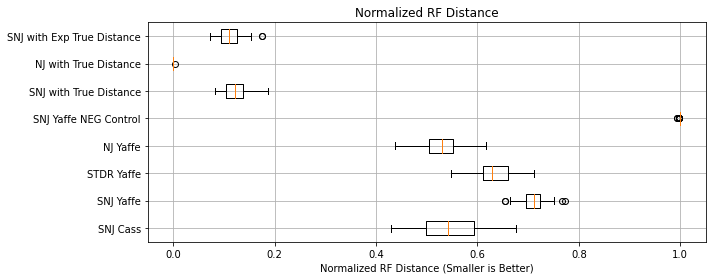

In [24]:
import matplotlib.pyplot as plt

plt.clf()
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.boxplot([
    metrics_df['RF'], 
    metrics_df['RF_og'], 
    metrics_df['RF_stdr'],
    metrics_df['RF_nj'],
    metrics_df['RF_snj_neg'],
    metrics_df['RF_snj_dists'],
    metrics_df['RF_nj_dists'],
    metrics_df['RF_snj_exp_dists'],
], vert = 0)
plt.title('Normalized RF Distance')
plt.xlabel('Normalized RF Distance (Smaller is Better)')
plt.yticks(list(range(1, len(metrics_df.columns)//2 + 1)), [
    'SNJ Cass', 
    'SNJ Yaffe', 
    'STDR Yaffe',
    'NJ Yaffe',
    'SNJ Yaffe NEG Control',
    'SNJ with True Distance',
    'NJ with True Distance',
    'SNJ with Exp True Distance',
])
# plt.xlim(0.07, 0.76)
plt.grid()
plt.tight_layout()
plt.savefig('RFs.plot.jpg')
plt.show()

<Figure size 432x288 with 0 Axes>

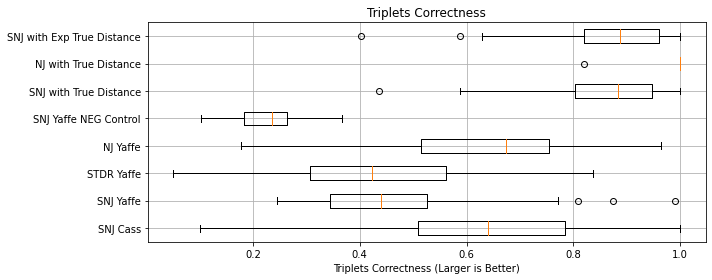

In [25]:
plt.clf()
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.boxplot([
    metrics_df['triplets'], 
    metrics_df['triplets_og'], 
    metrics_df['triplets_stdr'],
    metrics_df['triplets_nj'],
    metrics_df['triplets_snj_neg'],
    metrics_df['triplets_snj_dists'],
    metrics_df['triplets_nj_dists'],
    metrics_df['triplets_snj_exp_dists'],
], vert = 0)
plt.title('Triplets Correctness')
plt.xlabel('Triplets Correctness (Larger is Better)')
plt.yticks(list(range(1, len(metrics_df.columns)//2 + 1)), [
    'SNJ Cass', 
    'SNJ Yaffe', 
    'STDR Yaffe',
    'NJ Yaffe',
    'SNJ Yaffe NEG Control',
    'SNJ with True Distance',
    'NJ with True Distance',
    'SNJ with Exp True Distance',
])
# plt.xlim(0.29, 0.93)
plt.grid()
plt.tight_layout()
plt.savefig('tripletscorrect.plot.jpg')
plt.show()